In [2]:
## load useful libraries
suppressWarnings(suppressPackageStartupMessages(library(rhdf5)))
suppressWarnings(suppressPackageStartupMessages(library(qvalue)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(ggbeeswarm)))
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(scater)))
suppressWarnings(suppressPackageStartupMessages(library(SingleCellExperiment)))
suppressWarnings(suppressPackageStartupMessages(library(edgeR)))
suppressWarnings(suppressPackageStartupMessages(library(limma)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(ISLR)))
suppressWarnings(suppressPackageStartupMessages(library(GGally)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(ComplexHeatmap)))
suppressWarnings(suppressPackageStartupMessages(library(circlize)))

In [5]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [4]:
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [6]:
sce.slalom = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.slalom.is_intop2000hvg.rds")

In [7]:
coexpr_clusters_filename = "/nfs/leia/research/stegle/dseaton/hipsci/singlecell_endodiff/data/sce_merged_afterqc_filt_allexpts.PCA.cluster_means.tsv"
coexpr_clusters <- read.csv(coexpr_clusters_filename, row.names = 1, sep = "\t", header = T)
head(coexpr_clusters)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59
21843_1#10,-2.96677786,-5.051700,2.557705,1.7846318,-3.8000932,2.7520889,0.04011419,-0.65210263,-2.4088645,-1.4745952,⋯,0.9746980,1.157624,1.0561422,0.6647575,1.0319868,0.9611851,1.1291618,1.1297945,1.105578,1.475525
21843_1#100,2.99582684,-9.416975,3.945243,4.6289860,-1.2671332,1.6378075,0.24622875,2.11823943,-0.1742999,-1.1184431,⋯,0.8779742,1.035389,0.7064237,0.7908379,0.9249539,0.9632030,0.9793299,0.9073227,1.006672,1.317119
21843_1#101,-0.08867775,-6.769028,5.613472,1.8904508,-1.3355565,0.6089684,0.80128325,0.42480083,1.0950508,1.1932872,⋯,0.9319036,1.083866,0.8746851,0.6844323,0.9858303,0.9590457,1.1212404,1.1387067,1.041555,1.390104
21843_1#102,-5.00171746,-4.727163,2.400886,2.0255520,-2.0095244,5.2201763,1.46083794,-1.89020695,-0.4836101,0.6099583,⋯,0.9637354,1.166783,1.0856965,0.5970522,1.0349560,0.8610726,1.1574574,1.1208192,1.088636,1.499318
21843_1#103,-2.08193872,-6.209893,4.675325,0.5933318,-0.6481828,3.4695832,-0.36674697,-0.72786039,-0.6366988,0.3395057,⋯,1.0077623,1.192433,1.0881635,0.6984261,0.9993791,0.9143417,1.0999614,1.0552629,1.053882,1.557355
21843_1#105,-0.71012454,-6.392112,4.809889,0.5048616,-0.4834257,1.2074208,3.08038259,0.05347892,-1.7887607,-2.4269346,⋯,0.9450494,1.060659,1.0799314,0.8152264,0.9843815,0.9029240,1.0742548,1.1586082,1.167950,1.494102


In [8]:
## HVGs (highly variable genes)
# library(scran)
sce = normalize(sce)
design = model.matrix(~ experiment, data = colData(sce))
alt.fit = trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp = decomposeVar(sce, alt.fit)

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

In [9]:
top.100hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:100]
top.200hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:200]
top.500hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:500]
top.1000hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:1000]
top.2000hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:2000]

In [10]:
rowData(sce)$is_intop100hvg <- (rownames(sce) %in% top.100hvgs)
rowData(sce)$is_intop200hvg <- (rownames(sce) %in% top.200hvgs)
rowData(sce)$is_intop500hvg <- (rownames(sce) %in% top.500hvgs)
rowData(sce)$is_intop1000hvg <- (rownames(sce) %in% top.1000hvgs)
rowData(sce)$is_intop2000hvg <- (rownames(sce) %in% top.2000hvgs)

In [11]:
hvgs <- rownames(alt.decomp[alt.decomp$FDR < 0.01,])
rowData(sce)$is_hvg <- (rownames(sce) %in% hvgs)

In [12]:
length(hvgs)

[1] 4546

In [13]:
pca.hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_hvg,])))$x
pca.100hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop100hvg,])))$x
pca.200hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop200hvg,])))$x
pca.500hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop500hvg,])))$x
pca.1000hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop1000hvg,])))$x
pca.2000hvgs= prcomp(t(logcounts(sce[rowData(sce)$is_intop2000hvg,])))$x

In [14]:
sce$PC1_top100hvgs = pca.100hvgs[,1]
sce$PC1_top200hvgs = pca.200hvgs[,1]
sce$PC1_top500hvgs = pca.500hvgs[,1]
sce$PC1_top1000hvgs = pca.1000hvgs[,1]
sce$PC1_top2000hvgs = pca.2000hvgs[,1]

In [22]:
compare_pseudotimes <- function(pseudo1,pseudo2){
    df = data.frame(pseudo1 = pseudo1, pseudo2 = pseudo2, day = sce.slalom$day)
    p = ggplot(df, aes(x = pseudo1, y = pseudo2, colour = day)) 
    p = p + geom_point(alpha = 0.1, size = 0.8) 
    p = p + scale_color_canva(palette = "Pool party") 
    p = p + theme_bw() + theme(legend.position = "none", panel.border = element_blank())
    p = p + ggtitle(paste0("corr: ",round(cor(pseudo1,pseudo2),digits = 2)))
    p = p + theme(plot.title = element_text(hjust = 0.5))
    p
}

In [16]:
library(princurve)
princ.curve = principal.curve(x = pca.500hvgs[,1:2])

In [17]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
pseudo <- range01(princ.curve$lambda)

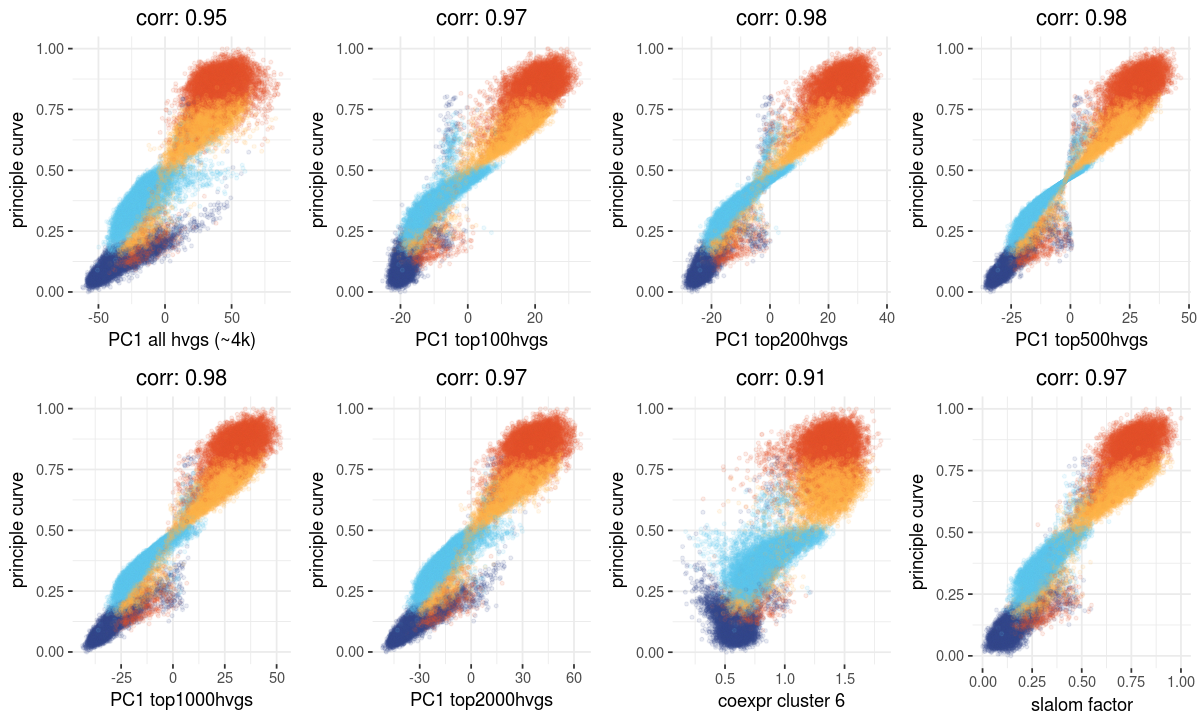

In [23]:
p1 = compare_pseudotimes(pca.hvgs[,"PC1"],pseudo) + xlab("PC1 all hvgs (~4k)") + ylab("principle curve")
p2 = compare_pseudotimes(pca.100hvgs[,"PC1"],pseudo) + xlab("PC1 top100hvgs") + ylab("principle curve")
p3 = compare_pseudotimes(pca.200hvgs[,"PC1"],pseudo) + xlab("PC1 top200hvgs") + ylab("principle curve")
p4 = compare_pseudotimes(pca.500hvgs[,"PC1"],pseudo) + xlab("PC1 top500hvgs") + ylab("principle curve")
p5 = compare_pseudotimes(pca.1000hvgs[,"PC1"],pseudo) + xlab("PC1 top1000hvgs") + ylab("principle curve")
p6 = compare_pseudotimes(pca.2000hvgs[,"PC1"],pseudo) + xlab("PC1 top2000hvgs") + ylab("principle curve")
p7 = compare_pseudotimes(coexpr_clusters[,"X6"],pseudo) + xlab("coexpr cluster 6") + ylab("principle curve")
p8 = compare_pseudotimes(sce.slalom$pseudo, pseudo) + xlab("slalom factor") + ylab("principle curve")
options(repr.plot.width = 10, repr.plot.height = 6)
plot_grid(p1, p2, p3, p4, p5, p6, p7, p8, ncol = 4)

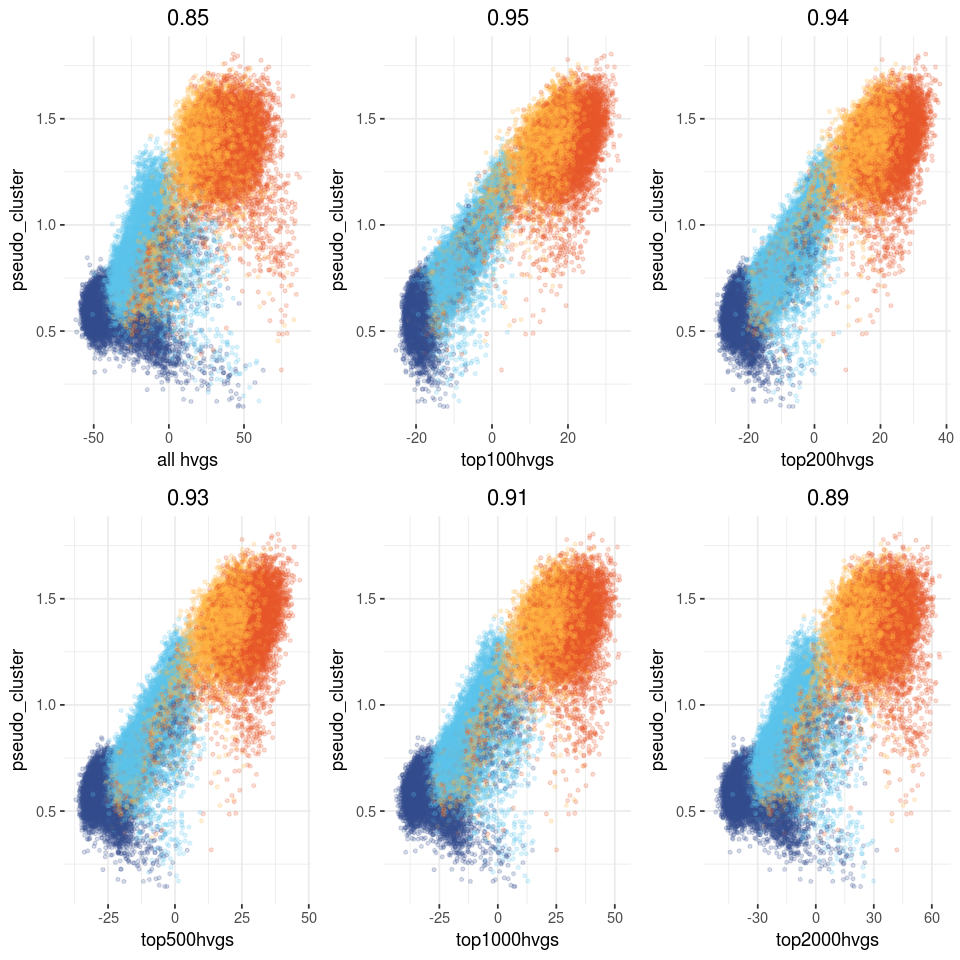

In [18]:
# p1 = compare_pseudotimes(coexpr_clusters[,"PC1"],coexpr_clusters[,"X6"]) + xlab("PC1_all") + ylab("pseudo_cluster")
p1 = compare_pseudotimes(pca.hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("all hvgs") + ylab("pseudo_cluster")
p2 = compare_pseudotimes(pca.100hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("top100hvgs") + ylab("pseudo_cluster")
p3 = compare_pseudotimes(pca.200hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("top200hvgs") + ylab("pseudo_cluster")
p4 = compare_pseudotimes(pca.500hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("top500hvgs") + ylab("pseudo_cluster")
p5 = compare_pseudotimes(pca.1000hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("top1000hvgs") + ylab("pseudo_cluster")
p6 = compare_pseudotimes(pca.2000hvgs[,"PC1"],coexpr_clusters[,"X6"]) + xlab("top2000hvgs") + ylab("pseudo_cluster")
options(repr.plot.width = 8, repr.plot.height = 8)
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 3)

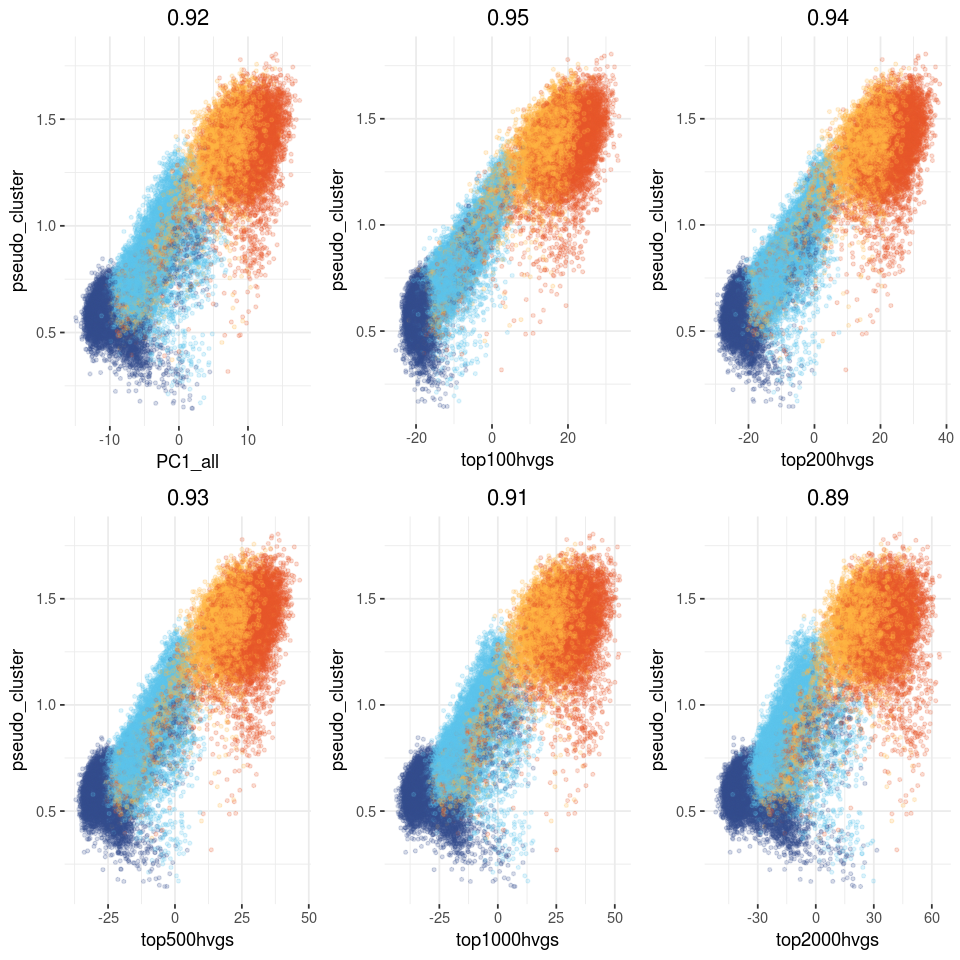

In [17]:
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 3)

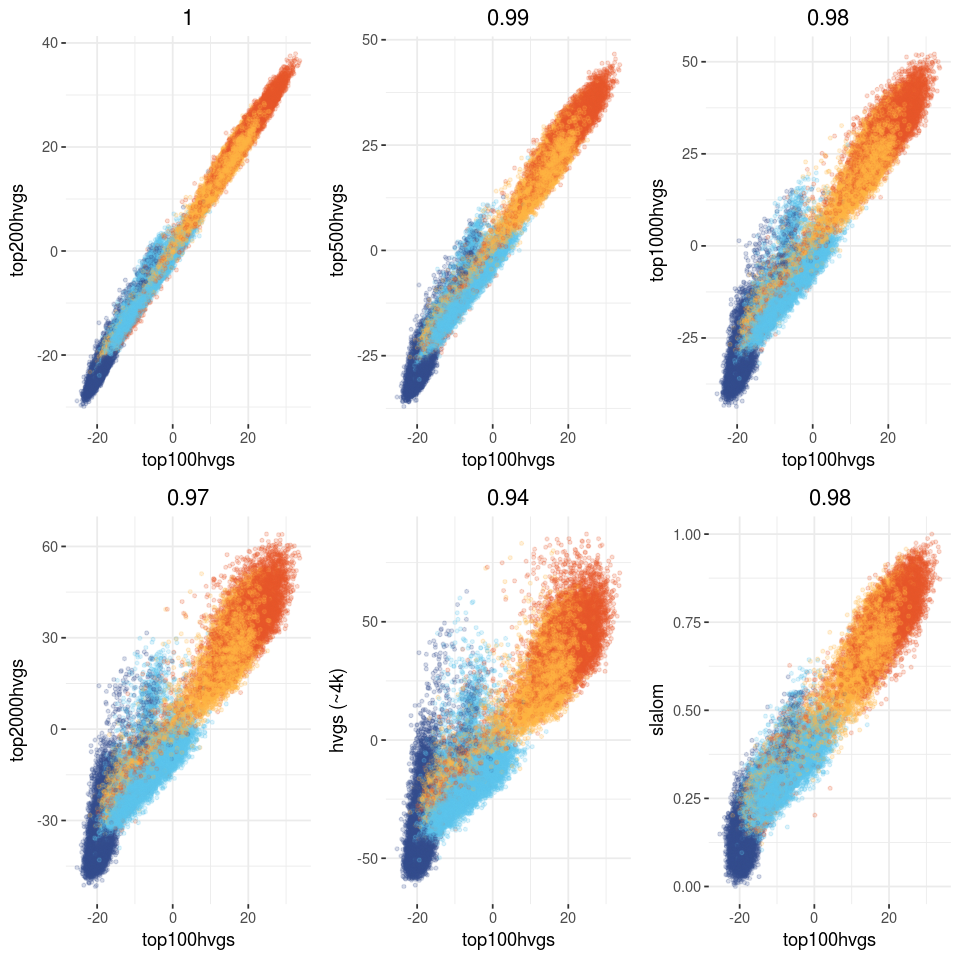

In [16]:
p1 = compare_pseudotimes(pca.100hvgs[,"PC1"],pca.200hvgs[,"PC1"]) + xlab("top100hvgs") + ylab("top200hvgs")
p2 = compare_pseudotimes(pca.100hvgs[,"PC1"],pca.500hvgs[,"PC1"]) + xlab("top100hvgs") + ylab("top500hvgs")
p3 = compare_pseudotimes(pca.100hvgs[,"PC1"],pca.1000hvgs[,"PC1"]) + xlab("top100hvgs") + ylab("top1000hvgs")
p4 = compare_pseudotimes(pca.100hvgs[,"PC1"],pca.2000hvgs[,"PC1"]) + xlab("top100hvgs") + ylab("top2000hvgs")
p5 = compare_pseudotimes(pca.100hvgs[,"PC1"],pca.hvgs[,"PC1"]) + xlab("top100hvgs") + ylab("hvgs (~4k)")
p6 = compare_pseudotimes(pca.100hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top100hvgs") + ylab("slalom")
options(repr.plot.width = 8, repr.plot.height = 8)
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 3)

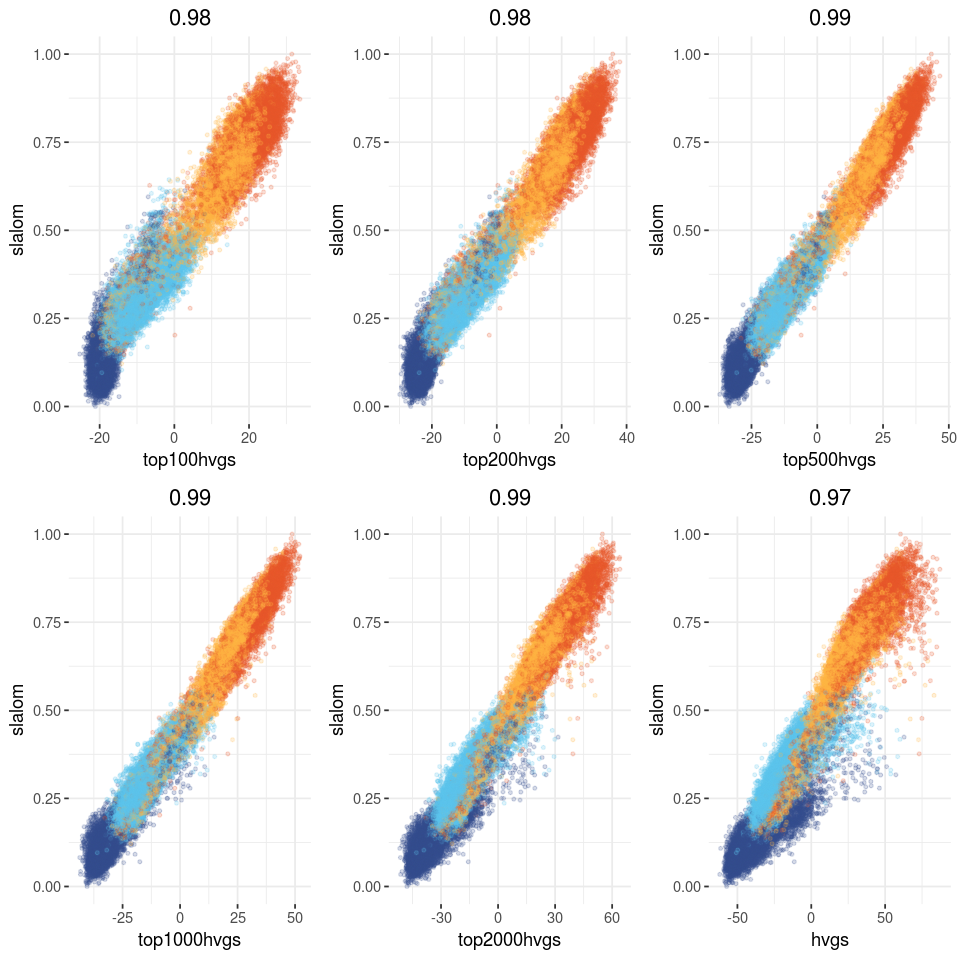

In [32]:
p1 = compare_pseudotimes(pca.100hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top100hvgs") + ylab("slalom")
p2 = compare_pseudotimes(pca.200hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top200hvgs") + ylab("slalom")
p3 = compare_pseudotimes(pca.500hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top500hvgs") + ylab("slalom")
p4 = compare_pseudotimes(pca.1000hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top1000hvgs") + ylab("slalom")
p5 = compare_pseudotimes(pca.2000hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top2000hvgs") + ylab("slalom")
p6 = compare_pseudotimes(pca.hvgs[,"PC1"],sce.slalom$pseudo) + xlab("hvgs") + ylab("slalom")
options(repr.plot.width = 8, repr.plot.height = 8)
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 3)

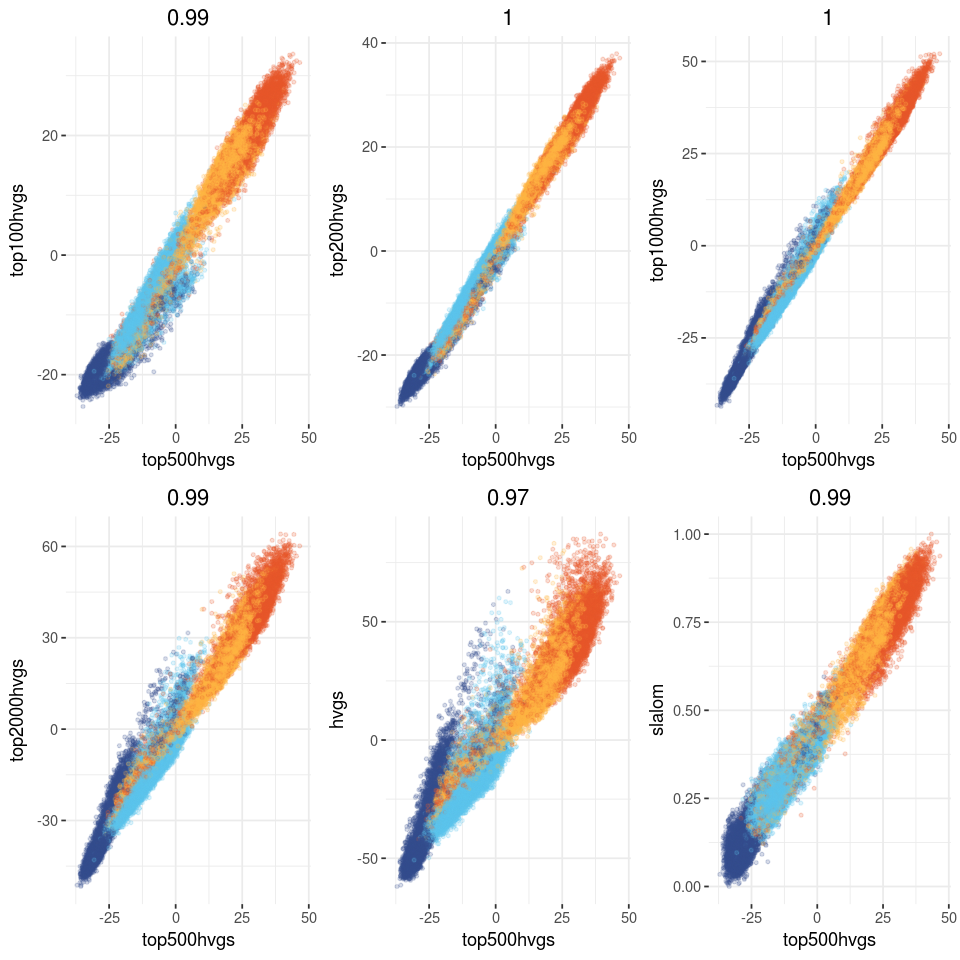

In [33]:
p1 = compare_pseudotimes(pca.500hvgs[,"PC1"],pca.100hvgs[,"PC1"]) + xlab("top500hvgs") + ylab("top100hvgs")
p2 = compare_pseudotimes(pca.500hvgs[,"PC1"],pca.200hvgs[,"PC1"]) + xlab("top500hvgs") + ylab("top200hvgs")
p3 = compare_pseudotimes(pca.500hvgs[,"PC1"],pca.1000hvgs[,"PC1"]) + xlab("top500hvgs") + ylab("top1000hvgs")
p4 = compare_pseudotimes(pca.500hvgs[,"PC1"],pca.2000hvgs[,"PC1"]) + xlab("top500hvgs") + ylab("top2000hvgs")
p5 = compare_pseudotimes(pca.500hvgs[,"PC1"],pca.hvgs[,"PC1"]) + xlab("top500hvgs") + ylab("hvgs")
p6 = compare_pseudotimes(pca.500hvgs[,"PC1"],sce.slalom$pseudo) + xlab("top500hvgs") + ylab("slalom")
options(repr.plot.width = 8, repr.plot.height = 8)
plot_grid(p1, p2, p3, p4, p5, p6, ncol = 3)

In [20]:
library(destiny)


Attaching package: ‘destiny’

The following object is masked from ‘package:SummarizedExperiment’:

    distance

The following object is masked from ‘package:GenomicRanges’:

    distance

The following object is masked from ‘package:IRanges’:

    distance



In [ ]:
data <- logcounts(sce[rowData(sce)$is_intop200hvg,])
diffMap <- DiffusionMap(t(data), sigma = "local", distance = "euclidean")

In [ ]:
dm <- as.data.frame(diffMap@eigenvectors[,1:8])
row.names(dm) <- colnames(data)

In [ ]:
dm$day = sce[rowData(sce)$is_hvg,"day"]

In [ ]:
plot(dm, 1:2,
col_by = 'day',
legend_main = 'Cell stage')

In [ ]:
plotids3 <- with(dm, plot3d(DC1, DC3, DC2, type = "s", size = 1, xlab = "DC1", 
                            ylab = "DC3", zlab = "DC2", col = sce_hvg$cluster))
rglwidget(elementId = "plot3drgl3", width = 600, height = 600)